In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from scipy.optimize import curve_fit
from scipy import odr
import seaborn as sns
import scipy.signal as sig
from astropy.table import Table
from astropy.io import ascii

sns.set_context('poster')
sns.set_style('ticks')
sns.set_palette('colorblind')

#distance (3Mpc) in cm from Koribalski+ 2004, H=70km/s/Mpc, 
distance = 9.3E24
area = 4*np.pi*np.square(distance)

def superorbital(x, P, phi):
	return 0.06*np.square(np.cos((np.pi*x/P) + phi)) + 0.01

# def superorbital(x, P, phi, C):
# 	return A*np.square(np.cos((np.pi*x/P) + phi)) + C

def powerlaw(beta, x):
	A, n = beta
	return A*np.power(x, n)

def powerlaw_inv(beta, y):
    A, n = beta
    return np.power(y/A, 1/n)

# QDP Plotting

In [7]:
cutoff = 0.016
start_met = 146771221.0
qdp_data = []
with open('/Users/sean/Desktop/CircinusULX5/2020/USERPROD_131.215.197.216_1581646219831/lc/curve_plot.qdp') as qdp_file:
    for line in qdp_file:
        if ('READ' not in line) and ('NO' not in line) and ('!' not in line) and (float(line.split()[0]) > 58400):
            qdp_data.append([float(x) for x in line.split()])
qdp_data = np.array(qdp_data).T
uplims = qdp_data[4]==0

/Users/sean/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


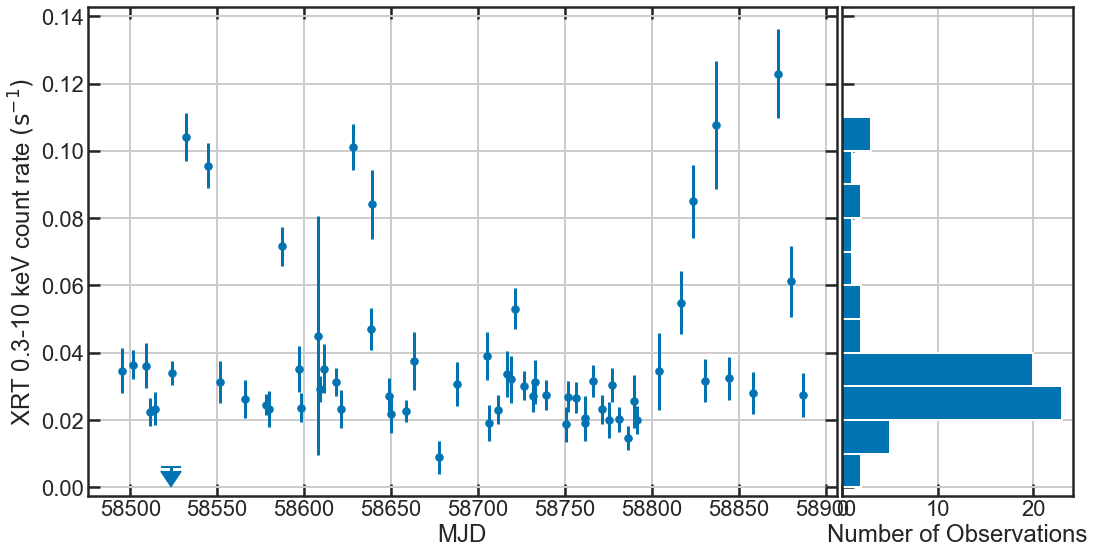

In [8]:
left, width = 0.1, 0.65
bottom, height = 0.1, 0.85
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(16, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)
# ax_scatter.set_yscale('log')

# the scatter plot:
ax_scatter.errorbar(qdp_data[0][~uplims], qdp_data[3][~uplims], xerr=qdp_data[1][~uplims], yerr=qdp_data[4][~uplims], \
             fmt='.', color='C0', ms=15)
ax_scatter.errorbar(qdp_data[0][uplims], qdp_data[3][uplims], yerr=0.001, \
                    uplims=[True for i in range(np.sum(uplims))], fmt='none', color='C0', ms=25, capsize=10, capthick=2)
# ax_scatter.axhline(0.08, color='red', ls='--')
# ax_scatter.axhline(0.13, color='magenta', label='0824450301')
# ax_scatter.axhline(0.08, color='C1', label='0792382701')
# ax_scatter.legend(title='Observation Target',title_fontsize=20)
# ax_scatter.legend(title='XMM OBSID', title_fontsize=20)
ax_scatter.set_ylabel(r'XRT 0.3-10 keV count rate $(\mathrm{s^{-1}})$')
ax_scatter.set_xlabel('MJD')
# ax_scatter.set_yscale('log')
ax_histy.hist(qdp_data[3], orientation='horizontal', bins=(np.arange(0, 0.12, 0.01)))
# ax_histy.set_yscale('log')
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_histy.set_xlabel('Number of Observations')
ax_scatter.grid()
ax_histy.grid()
plt.tight_layout()
plt.savefig('/Users/sean/Desktop/CircinusULX5/2020/XRT_countrate_hist_2020.pdf')



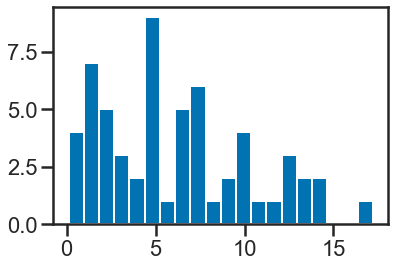

In [6]:
qdp_data[4][uplims] = qdp_data[3][uplims]
sorted_args = np.argsort(qdp_data[0])
plt.hist(qdp_data[0][sorted_args][1:]-qdp_data[0][sorted_args][:-1], bins=20)
bin_time = 10
bin_array = np.arange(np.min(qdp_data[0]), np.max(qdp_data[0]) + bin_time, bin_time)
plot_bin_array = np.arange(np.min(qdp_data[0]), np.max(qdp_data[0]) + bin_time, bin_time)[:-1]
binned_rate = []
binned_err = []
for i in range(len(bin_array)-1):
    temp_mask = (qdp_data[0] < bin_array[i +1]) * (qdp_data[0] > bin_array[i])
    binned_rate.append(np.mean(qdp_data[3][temp_mask]))
    binned_err.append(np.mean(qdp_data[4][temp_mask]))
binned_mask = ~np.isnan(binned_rate)
binned_rate = np.array(binned_rate)
binned_err = np.array(binned_err)



/Users/sean/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


32
0.21875
0.02465190328815662
60


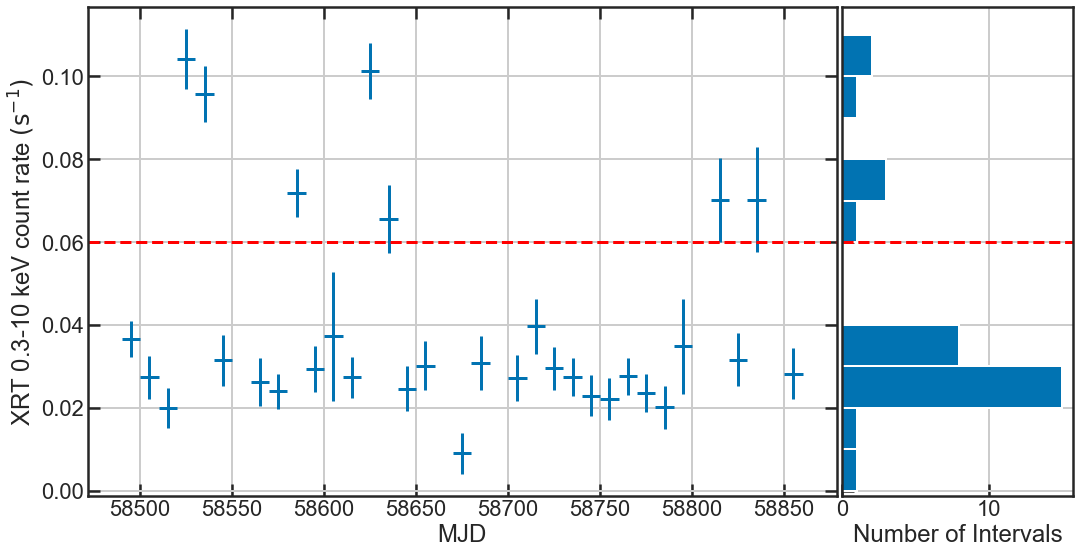

In [10]:
left, width = 0.1, 0.65
bottom, height = 0.1, 0.85
spacing = 0.005
trig_thresh = 0.06


rect_scatter = [left, bottom, width, height]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(16, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.errorbar(plot_bin_array[binned_mask], binned_rate[binned_mask], xerr=bin_time/2, yerr = binned_err[binned_mask], \
             fmt='none', color='C0', label='Circinus ULX5', ms=25)
ax_scatter.axhline(trig_thresh, color='red', ls='--')
# ax_scatter.set_ylim((7e-3,ax_scatter.get_ylim()[1]))
# ax_scatter.legend(title='Observation Target',title_fontsize=20)

ax_scatter.set_ylabel(r'XRT 0.3-10 keV count rate $(\mathrm{s^{-1}})$')
ax_scatter.set_xlabel('MJD')
# ax_scatter.set_yscale('log')
ax_histy.hist(binned_rate[binned_mask], orientation='horizontal', bins=(np.arange(0.0, 0.12, 0.01)))
# ax_histy.set_yscale('log')
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_histy.set_xlabel('Number of Intervals')
ax_histy.axhline(trig_thresh, color='red', ls='--')
ax_scatter.grid()
ax_histy.grid()
plt.tight_layout()
plt.savefig('/Users/sean/Desktop/CircinusULX5/XRT_countrate_threshold_NuSTAR2020.pdf')
print(np.sum(binned_mask))
print(7/32)
print((1-(7/32))**15)
print(len(qdp_data[0]))
